In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
import sympy as smp
from IPython.display import display as disp
import lablib as ll
%matplotlib inline
mp.rc("savefig", dpi=96)

Загружаем данные, приводим к СИ. Время будем рассматривать в мкс, а напряжения в мВ, чтобы не терять точность.

In [2]:
data, columns, experiments = ll.read_standard_layout()

e = "main"

ll.compute(name = "T",
           expr = lambda T: T + 273,
           data = data[e],
           columns = columns[e])

disp(data[e], columns[e])

,Value,Error,ErrorRel
t_0,6.956400,0.000100,0.00%
_dT_dU,24.000000,0.500000,2.08%


,T,Error_T,ErrorRel_T,U,Error_U,ErrorRel_U,t,Error_t,ErrorRel_t
0,290.770000,0.010000,0.00%,-0.002000,0.001200,-60.00%,7.828600,0.000100,0.00%
1,291.030000,0.010000,0.00%,-0.004000,0.001200,-30.00%,7.811500,0.000100,0.00%
2,293.060000,0.010000,0.00%,-0.017000,0.001200,-7.06%,7.650000,0.000100,0.00%
3,295.080000,0.010000,0.00%,-0.017000,0.001200,-7.06%,7.440000,0.000100,0.00%
4,298.080000,0.010000,0.00%,-0.015000,0.001200,-8.00%,7.212000,0.000100,0.00%
5,303.080000,0.010000,0.00%,-0.013000,0.001200,-9.23%,7.108500,0.000100,0.00%
6,308.060000,0.010000,0.00%,-0.015000,0.001200,-8.00%,7.072000,0.000100,0.00%
7,313.050000,0.010000,0.00%,-0.012000,0.001200,-10.00%,7.053500,0.000100,0.00%


Корректируем температуру согласно показаниям с термопары:

$T_{образца} = T_{воды} + \Delta U * \frac{dT}{dU}_{термопары}$


In [3]:
ll.compute(name = "T",
           expr = lambda T, U, _dT_dU: T + U * _dT_dU,
           data = data[e],
           columns = columns[e])
    
disp(data[e], columns[e])

,Value,Error,ErrorRel
t_0,6.956400,0.000100,0.00%
_dT_dU,24.000000,0.500000,2.08%


,T,Error_T,ErrorRel_T,U,Error_U,ErrorRel_U,t,Error_t,ErrorRel_t
0,290.722000,0.030503,0.01%,-0.002000,0.001200,-60.00%,7.828600,0.000100,0.00%
1,290.934000,0.030552,0.01%,-0.004000,0.001200,-30.00%,7.811500,0.000100,0.00%
2,292.652000,0.031649,0.01%,-0.017000,0.001200,-7.06%,7.650000,0.000100,0.00%
3,294.672000,0.031649,0.01%,-0.017000,0.001200,-7.06%,7.440000,0.000100,0.00%
4,297.720000,0.031396,0.01%,-0.015000,0.001200,-8.00%,7.212000,0.000100,0.00%
5,302.768000,0.031172,0.01%,-0.013000,0.001200,-9.23%,7.108500,0.000100,0.00%
6,307.700000,0.031396,0.01%,-0.015000,0.001200,-8.00%,7.072000,0.000100,0.00%
7,312.762000,0.031072,0.01%,-0.012000,0.001200,-10.00%,7.053500,0.000100,0.00%


Вычислим промежуточные данные $(\tau^2 - \tau_0^2) \propto \chi \propto \frac{1}{T - \Theta_p}$ и построим график $(\tau^2 - \tau_0^2) = f(T)$.

Заодно приблизим теоретической кривой $f(T) \propto \frac{1}{T - \Theta_p}$, получая для неё результат в $\Theta_p = 290 \pm 0.9 °K$.

Initial guesses for chi:
                Value    Error  ErrorRel
k_1        25.436974 0.019176  0.000754
theta_p_1 290.996524 0.003219  0.000011


'Final guesses for chi:'

,Value,Error,ErrorRel
k_1,29.497409,1.898427,6.44%
theta_p_1,289.827021,0.854083,0.29%


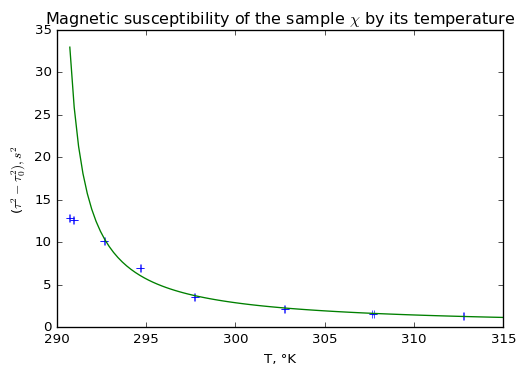

In [4]:
ll.compute(name = "tsq_minus_t0sq",
           expr = lambda t, t_0: t**2 - t_0**2,
           data = data[e],
           columns = columns[e])

model = ll.fit2(name = "chi",
                model = lambda T, k_1, theta_p_1: k_1 / (T - theta_p_1),
                x = list(columns[e]["T"][3:]),
                xerr = list(columns[e]["Error_T"][3:]),
                y = list(columns[e]["tsq_minus_t0sq"][3:]),
                yerr = list(columns[e]["Error_tsq_minus_t0sq"][3:]),
                data = data[e])

linspace = ll.linspace(columns[e]["T"])

plt.title("Magnetic susceptibility of the sample $\\chi$ by its temperature")
plt.xlabel("T, °K")
plt.ylabel("($\\tau^2 - \\tau_0^2), s^2$")
plt.errorbar(x = columns[e]["T"],
             xerr = columns[e]["Error_T"],
             y = columns[e]["tsq_minus_t0sq"],
             yerr = columns[e]["Error_tsq_minus_t0sq"],
             linestyle = "none")
plt.errorbar(x = linspace,
             y = model(linspace))
None

Таким же способом построим график $\frac{1}{\tau^2 - \tau_0^2} = f(T)$ и приблизим его прямой $f(T) \propto T - \Theta_p$.

Для этого метода получен результат в $\Theta_p = 289 \pm 0.5 °K$.

Initial guesses for _1_chi:
                Value    Error  ErrorRel
k_2         0.017504 0.000008  0.000436
theta_p_2 286.442010 0.002165  0.000008


'Final guesses for _1_chi:'

,Value,Error,ErrorRel
k_2,0.032230,0.001385,4.30%
theta_p_2,289.027715,0.452521,0.16%


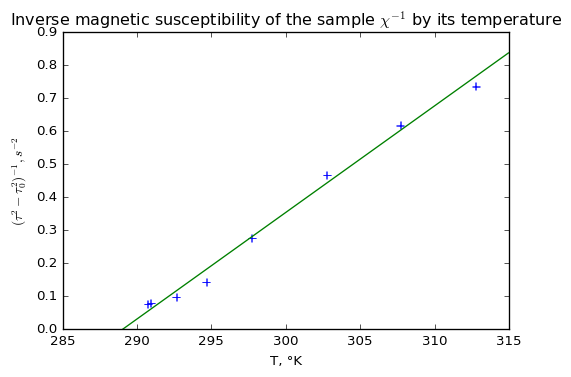

In [5]:
ll.compute(name = "_1_tsq_minus_t0sq",
           expr = lambda t, t_0: 1 / (t**2 - t_0**2),
           data = data[e],
           columns = columns[e])

model = ll.fit2(name = "_1_chi",
                model = lambda T, k_2, theta_p_2: k_2 * (T - theta_p_2),
                x = list(columns[e]["T"][0:]),
                xerr = list(columns[e]["Error_T"][0:]),
                y = list(columns[e]["_1_tsq_minus_t0sq"][0:]),
                yerr = list(columns[e]["Error__1_tsq_minus_t0sq"][0:]),
                data = data[e])

linspace = ll.linspace(columns[e]["T"], pre = 0.1)

plt.title("Inverse magnetic susceptibility of the sample $\\chi^{-1}$ by its temperature")
plt.xlabel("T, °K")
plt.ylabel("$(\\tau^2 - \\tau_0^2)^{-1}, s^{-2}$")
plt.errorbar(x = columns[e]["T"],
             xerr = columns[e]["Error_T"],
             y = columns[e]["_1_tsq_minus_t0sq"],
             yerr = columns[e]["Error__1_tsq_minus_t0sq"],
             linestyle = "none")
plt.errorbar(x = linspace,
             y = model(linspace))
plt.axis([None, None, 0, None])
None